# Yelp API Project


## Introduction 

We've learned how to query the Yelp API, analyze JSON data and create basic visualizations. It's time to put those skills to work in order to create a project of your own! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API.

## Objectives

You will be able to: 

* Practice using functions to organize your code
* Use pagination to retrieve all results from an API query
* Practice parsing data returned from an API query
* Practice interpreting visualizations of a dataset

# Task: Query Yelp for All Businesses in a Category and Analyze the Results

![restaurant counter with pizza](images/restaurant_counter.jpg)

Photo by <a href="https://unsplash.com/@jordanmadrid?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Jordan Madrid</a> on <a href="/s/photos/pizza-restaurant?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

## Overview

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. In this lab, you will write a query of businesses on Yelp, then use *pagination* to retrieve all possible results for that query. Then you will pre-process and analyze your data, leading to a presentation of your findings.

## Requirements

### 1. Make the Initial Request

Start by filling in your API key to make the initial request to the business search API. 

### 2. Add Pagination

Using loops and functions, collect the maximum number of results for your query from the API.

### 3. Prepare Data

Investigate the structure of the response you get back and extract the relevant information.

### 4. Perform Descriptive Analysis

Interpret visualizations related to the price range, average rating, and number of reviews for all query results.

### 5. Create Presentation Notebook

Edit this notebook or create a new one to showcase your work.

# 1. Make the Initial Request

## Querying

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you but make the request below.

Use the `requests` library ([documentation here](https://requests.readthedocs.io/en/master/user/quickstart/#make-a-request)).

You'll also need an API key from Yelp. If you haven't done this already, go to the Yelp [Manage App page](https://www.yelp.com/developers/v3/manage_app) and create a new app (after making an account if you haven't already).

In [1]:
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [4]:
# Replace None with appropriate code

# Import the requests library
import requests

# Get this from the "Manage App" page. Make sure you set them
# back to None before pushing this to GitHub, since otherwise
# your credentials will be compromised

keys = get_keys("yelp_api.json")
api_key = keys['api_key']

# These can be whatever you want! But the solution uses "pizza"
# and "New York NY" if you want to compare your work directly
term = "pizza"
location = "New York NY"
 
# Set up params for request
url = "https://api.yelp.com/v3/businesses/search"
headers = {
    "Authorization": "Bearer {}".format(api_key)
}
url_params = {
    "term": term.replace(" ", "+"),
    "location": location.replace(" ", "+")
}

# Make the request using requests.get, passing in
# url, headers=headers, and params=url_params
response = requests.get(url, headers=headers, params=url_params)
# https://www.yelp.com/developers/documentation/v3/business_search

# Confirm we got a 200 response

print(requests.codes.ok)
print(response.status_code == requests.codes.ok)

# dict(response.headers)
# print(response.url)
# print(response.text)

200
True


In [5]:
# Run this cell without changes

# Get the response body in JSON format
response_json = response.json()
# View the keys
response_json.keys()

dict_keys(['businesses', 'total', 'region'])

In [6]:
print('Business')
print(type(response_json['businesses']))
print(len(response_json['businesses']))

print('\nTotal')
print(type(response_json['total']))
print(response_json['total'])

print('\nRegion')
print(type(response_json['region'])) # Region key type = dict
region = response_json['region'] # Set region variable
print(type(region['center'])) # Center key type = dict
center = region['center'] # Set center variable
print(center.keys()) # Long / Lat

Business
<class 'list'>
20

Total
<class 'int'>
11800

Region
<class 'dict'>
<class 'dict'>
dict_keys(['longitude', 'latitude'])


## Extracting Data

Now, retrieve the value associated with the `'businesses'` key, and inspect its contents.

In [7]:
# Replace None with appropriate code

# Retrieve the value from response_json
businesses = response_json['businesses']

# View number of records
print(f"\nThere are {len(businesses)} businesses in this response")

# View the first 2 records
businesses[:2]


There are 20 businesses in this response


[{'id': 'zj8Lq1T8KIC5zwFief15jg',
  'alias': 'prince-street-pizza-new-york-2',
  'name': 'Prince Street Pizza',
  'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/ZAukOyv530w4KjOHC5YY1w/o.jpg',
  'is_closed': False,
  'url': 'https://www.yelp.com/biz/prince-street-pizza-new-york-2?adjust_creative=Autr_aWUiis-5UD_Bri39g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=Autr_aWUiis-5UD_Bri39g',
  'review_count': 3934,
  'categories': [{'alias': 'pizza', 'title': 'Pizza'},
   {'alias': 'italian', 'title': 'Italian'}],
  'rating': 4.5,
  'coordinates': {'latitude': 40.72308755605564,
   'longitude': -73.99453001177575},
  'transactions': ['pickup', 'delivery'],
  'price': '$',
  'location': {'address1': '27 Prince St',
   'address2': None,
   'address3': '',
   'city': 'New York',
   'zip_code': '10012',
   'country': 'US',
   'state': 'NY',
   'display_address': ['27 Prince St', 'New York, NY 10012']},
  'phone': '+12129664100',
  'display_phone': '(212) 966-4100'

# 2. Add Pagination

Now that you are able to get one set of responses, known as a **page**, let's figure out how to request as many pages as possible.

## Technical Details

Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the **API limits**. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a **maximum of 50 results per request** and defaults to 20. Furthermore, any search will be limited to a **total of 1000 results**. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

Also, be mindful of the **API** ***rate*** **limits**. You can only make **5000 requests per day** and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use `time.sleep(n)` to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a list of dictionaries (for further exploration) and create a map using Folium to visualize the results geographically.

## Determining the Total

Depending on the number of total results for your query, you will either retrieve all of the results, or just the first 1000 (if there are more than 1000 total).

We can find the total number of results using the `"total"` key:

In [8]:
# Run this cell without changes
response_json["total"]

11800

(This is specific to the implementation of the Yelp API. Some APIs will just tell you that there are more pages, or will tell you the number of pages total, rather than the total number of results. If you're not sure, always check the documentation.)

In the cell below, assign the variable `total` to either the value shown above (if it is less than 1000), or 1000.

In [9]:
# Replace None with appropriate code

if response_json["total"] < 1000:
    total = response_json["total"]
else:
    total = 1000
    
total

1000

### Calculating the Offsets

The documentation states in the parameters section:

> **Name**: `limit`, **Type:** int, **Description:** Optional. Number of business results to return. By default, it will return 20. Maximum is 50.

> **Name**: `offset`, **Type:** int, **Description:** Optional. Offset the list of returned business results by this amount.

So, to get the most results with the fewest API calls we want to set a limit of 50 every time. If, say, we wanted to get 210 total results, that would mean:

1. Offset of `0` (first 50 records)
2. Offset of `50` (second 50 records)
3. Offset of `100` (third 50 records)
4. Offset of `150` (fourth 50 records)
5. Offset of `200` (final 10 records)

In the cell below, create a function `get_offsets` that takes in a total and returns a list of offsets for that total. You can assume that there is a limit of 50 every time.

*Hint: you can use `range` ([documentation here](https://docs.python.org/3.3/library/stdtypes.html?highlight=range#range)) to do this in one line of code. Just make the returned result is a list.*

In [10]:
# Replace None with appropriate code
def get_offsets(total):
    """
    Get a list of offsets needed to get all pages
    of data up until the total
    """
    
    start = 0
    stop = total
    step = 50

    return list(range(start, stop, step))

    # https://www.programiz.com/python-programming/methods/built-in/range

Check that your function works below:

In [11]:
# Run this cell without changes

assert get_offsets(200) == [0, 50, 100, 150]
assert get_offsets(210) == [0, 50, 100, 150, 200]

# print(get_offsets(200))
# print(get_offsets(210))

### Putting It All Together

Recall that the following variable has already been declared for you:

In [12]:
# Run this cell without changes
url_params

{'term': 'pizza', 'location': 'New+York+NY'}

We'll go ahead and also specify that the limit should be 50 every time:

In [13]:
# Run this cell without changes
url_params["limit"] = 50

In order to modify the offset, you'll need to add it to `url_params` with the key `"offset"` and whatever value is needed.

In the cell below, write code that:

* Creates an empty list for the full prepared dataset
* Loops over all of the offsets from `get_offsets` and makes an API call each time with the specified offset
* Extends the full dataset list with each query's dataset

In [14]:
# Replace None with appropriate code

# Create an empty list for the full prepared dataset
full_dataset = []

for offset in get_offsets(total):
    # Add or update the "offset" key-value pair in url_params
    url_params["offset"] = offset
    
    # Make the query and get the response
    response = requests.get(url, headers=headers, params=url_params)
    
    # Get the response body in JSON format
    response_json = response.json()
    
    # Get the list of businesses from the response_json
    businesses = response_json['businesses']
    
    # Extend full_dataset with this list (don't append, or you'll get
    # a list of lists instead of a flat list)
    for business in businesses:
        full_dataset.append(business)

# Check the length of the full dataset. It will be up to `total`,
# potentially less if there were missing values
len(full_dataset)

1000

This code may take up to a few minutes to run.

If you get an error trying to get the response body in JSON format, try adding `time.sleep(1)` right after the `requests.get` line, so your code will sleep for 1 second between each API call.

# 3. Prepare Data

Now that we have all of our data, let's prepare it for analysis. It can be helpful to start this process by inspecting the raw data.

In [15]:
# Run this cell without changes

# View the first 2 records
# full_dataset[:2]
first_record = full_dataset[0]

In [17]:
first_record.keys()

dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'price', 'location', 'phone', 'display_phone', 'distance'])

In [19]:
print(first_record['name'])
print(first_record['review_count'])
print(first_record['rating'])
print(first_record['price'])
print(first_record['coordinates'])
print(first_record['coordinates']['latitude'])
print(first_record['coordinates']['longitude'])

Prince Street Pizza
3934
4.5
$
{'latitude': 40.72308755605564, 'longitude': -73.99453001177575}
40.72308755605564
-73.99453001177575


Write a function `prepare_data` that takes in a list of dictionaries like `businesses` and returns a copy that has been prepared for analysis:

1. The `coordinates` key-value pair has been converted into two separate key-value pairs, `latitude` and `longitude`
2. All other key-value pairs except for `name`, `review_count`, `rating`, and `price` have been dropped
3. All dictionaries missing one of the relevant keys or containing null values have been dropped

In other words, the final keys for each dictionary should be `name`, `review_count`, `rating`, `price`, `latitude`, and `longitude`.

Complete the function in the cell below:

In [20]:
# Replace None with appropriate code

def prepare_data(data_list):
    """
    This function takes in a list of dictionaries and prepares it
    for analysis
    """
    
    # Make a new list to hold results
    results = []
    keys = ['name', 'review_count', 'rating', 'price']
    
    for business_data in data_list:
    
        # Make a new dictionary to hold prepared data for this business
        prepared_data = {}
        
        # Extract name, review_count, rating, and price key-value pairs
        # from business_data and add to prepared_data
        
        business_keys = business_data.keys()
        
        # If a key is not present in business_data, add it to prepared_data
        # with an associated value of None
        
        for key in keys:
            if key in business_keys:
                prepared_data[key] = business_data[key]
            else:
                prepared_data[key] = 'None'    
                
#         prepared_data['name'] = business_data['name']
#         prepared_data['review_count'] = business_data['review_count']
#         prepared_data['rating'] = business_data['rating']
#         prepared_data['price'] = business_data['price']
                
        # Parse and add latitude and longitude columns
        
        prepared_data['latitude'] = business_data['coordinates']['latitude']
        prepared_data['longitude'] = business_data['coordinates']['longitude']
        
#         # Add to list if all values are present
#         if all(prepared_data.values()):
#             results.append(prepared_data)

        results.append(prepared_data)
    
    return results
    
# Test out function
prepared_businesses = prepare_data(full_dataset)
prepared_businesses[:5]

[{'name': 'Prince Street Pizza',
  'review_count': 3934,
  'rating': 4.5,
  'price': '$',
  'latitude': 40.72308755605564,
  'longitude': -73.99453001177575},
 {'name': "Juliana's",
  'review_count': 2338,
  'rating': 4.5,
  'price': '$$',
  'latitude': 40.70274718768062,
  'longitude': -73.99343490196397},
 {'name': "Lombardi's Pizza",
  'review_count': 6179,
  'rating': 4.0,
  'price': '$$',
  'latitude': 40.7215934960083,
  'longitude': -73.9955956044561},
 {'name': 'Lucali',
  'review_count': 1697,
  'rating': 4.0,
  'price': '$$',
  'latitude': 40.6818,
  'longitude': -74.00024},
 {'name': 'Rubirosa',
  'review_count': 2420,
  'rating': 4.5,
  'price': '$$',
  'latitude': 40.722766,
  'longitude': -73.996233}]

Check that your function created the correct keys:

In [21]:
# Run this cell without changes

assert sorted(list(prepared_businesses[0].keys())) == ['latitude', 'longitude', 'name', 'price', 'rating', 'review_count']

The following code will differ depending on your query, but there may be fewer results in the prepared list than in the full dataset (if any of them were missing data):

In [22]:
# Run this cell without changes
print("Original:", len(full_dataset))
print("Prepared:", len(prepared_businesses))

Original: 1000
Prepared: 1000


Great! Now let's create a DataFrame to hold our data - this will make our cleaning and analysis easier.

In [23]:
# Replace None with appropriate code

# Import pandas
import pandas as pd

# Create DataFrame from prepared business data
business_df = pd.DataFrame(prepared_businesses)

# Inspect the DataFrame
business_df.head()

,name,review_count,rating,price,latitude,longitude
0,Prince Street Pizza,3934,4.5,$,40.723088,-73.994530
1,Juliana's,2338,4.5,$$,40.702747,-73.993435
2,Lombardi's Pizza,6179,4.0,$$,40.721593,-73.995596
3,Lucali,1697,4.0,$$,40.681800,-74.000240
4,Rubirosa,2420,4.5,$$,40.722766,-73.996233


In [26]:
print('Dataframe info')
# https://www.datacamp.com/community/blog/python-pandas-cheat-sheet

print(business_df.shape)
print(business_df.index)
print(business_df.columns)
# print(business_df.count)
print(business_df.dtypes)
# print(business_df.info)
# print(business_df.describe)

Dataframe info
(1000, 6)
RangeIndex(start=0, stop=1000, step=1)
Index(['name', 'review_count', 'rating', 'price', 'latitude', 'longitude'], dtype='object')
name             object
review_count      int64
rating          float64
price            object
latitude        float64
longitude       float64
dtype: object


To make analysis of prices easier, let's convert `price` to a numeric value indicating the number of dollar signs.

In [27]:
# Replace None with appropriate code

business_df['price'] = (business_df['price']).str.len()

# business_df['price'] = business_df['price'].replace('$', "1")
# business_df['price'] = business_df['price'].replace('$$', "2")
# business_df['price'] = business_df['price'].replace('$$$', "3")
# business_df['price'] = business_df['price'].replace('$$$$', "4")
# https://www.geeksforgeeks.org/python-pandas-series-str-replace-to-replace-text-in-a-series/

# business_df['price'] = business_df['price'].apply(pd.to_numeric)
# https://intellipaat.com/community/2601/change-data-type-of-columns-in-pandas

# business_df.loc[business_df['price'] == '$', 'price'] = 1
# business_df.loc[business_df['price'] == '$$', 'price'] = 2
# business_df.loc[business_df['price'] == '$$$', 'price'] = 3
# business_df.loc[business_df['price'] == '$$$$', 'price'] = 4

# business_df['price'] =  business_df['price'].astype(int)

business_df.head()

,name,review_count,rating,price,latitude,longitude
0,Prince Street Pizza,3934,4.5,1,40.723088,-73.994530
1,Juliana's,2338,4.5,2,40.702747,-73.993435
2,Lombardi's Pizza,6179,4.0,2,40.721593,-73.995596
3,Lucali,1697,4.0,2,40.681800,-74.000240
4,Rubirosa,2420,4.5,2,40.722766,-73.996233


# 4. Perform Descriptive Analysis

## Descriptive Statistics

Take the businesses from the previous question and do an initial descriptive analysis. Calculate summary statistics for the review counts, average rating, and price.

In [28]:
# Replace None with appropriate code

# Calculate summary statistics for the review counts, average rating, and price
# print('Mean')
# print('Review count: ', business_df['review_count'].mean())
# print('Rating: ', business_df['rating'].mean().round(2))
# print('Price: ', business_df['price'].mean().round(2))

# print('\nMedian')
# print('Review count: ', business_df['review_count'].median())
# print('Rating: ', business_df['rating'].median())
# print('Price: ', business_df['price'].median())

# # print('\nRatings')
# # business_df.groupby('rating').sum()

# print('\nStandard deviation')
# print('Review count: ', business_df['review_count'].std().round(2))
# print('Rating: ', business_df['rating'].std().round(2))
# print('Price: ', business_df['price'].std().round(2))

business_df[['price', 'rating', 'review_count']].describe().round(2)

,price,rating,review_count
count,1000.00,1000.00,1000.00
mean,2.14,3.99,346.68
std,1.11,0.52,608.11
min,1.00,1.00,1.00
25%,1.00,3.50,49.75
50%,2.00,4.00,160.00
75%,3.00,4.50,383.25
max,4.00,5.00,6385.00


Describe the results displayed above and interpret them in the context of your query. (Your answer may differ from the solution branch depending on your query.)

In [48]:
# Replace None with appropriate text
"""
Using a selection of 1000 Yelp restaurant reviews of New York 'pizza' restaurants, we can see that:
- Each restaurant has on average 350 reviews (Source: Mean)
- The average rating is 4 out of 5 (Source: Mean & Median)
- Do something about the max (review_count)
"""

"\nUsing a selection of 1000 Yelp restaurant review of New York 'pizza' restaurants, we can see that:\n- Each restaurant has on average 350 reviews (Source: Mean)\n- The average rating is 4 out of 5 (Source: Mean & Median)\n"

## Histograms

Create histograms for the review counts, average rating, and price.

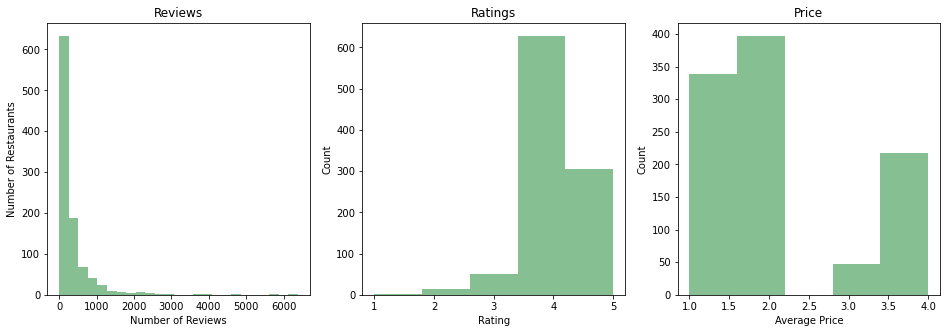

In [29]:
# Replace None with your code
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 5))

# Plot distribution of number of reviews per business
all_review_counts = ax1.hist(business_df['review_count'], bins=25, color='#86bf91')

ax1.set(title = "Reviews",
       xlabel = "Number of Reviews", 
       ylabel = "Number of Restaurants")

# Plot distribution of ratings across businesses
all_ratings = ax2.hist(business_df['rating'], bins=5, color='#86bf91')

ax2.set(title = "Ratings",
       xlabel = "Rating", 
       ylabel = "Count")

# Plot distribution of prices across businesses
all_prices = ax3.hist(business_df['price'], bins=5, color='#86bf91')

ax3.set(title = "Price",
       xlabel = "Average Price", 
       ylabel = "Count");

# https://matplotlib.org/stable/gallery/statistics/hist.html
# https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-with-matplotlib/introduction-to-matplotlib-plots/customize-plot-colors-labels-matplotlib/

Describe the distributions displayed above and interpret them in the context of your query. (Your answer may differ from the solution branch depending on your query.)

In [ ]:
# Replace None with appropriate text
"""
From the Reviews Histogram we can see that:
- There is a large spread in the amount of reviews across restaurants - 0 to ~6000 reviews (review this)
- Most restaurants have <1000 reviews, with the majority <500
- This data is heavily skewed

From the Ratings Histogram we can infer that:
- The most common rating is 4 out of 5 stars
- The second most common is 5 out of 5
- This data is heavily skewed

From the Price Histogram we can see that:
- The majority of reviews give a price rating of 1 - 2 = $ & $$
"""

## Ratings vs. Price

Create a visualization showing the relationship between rating and price. You can do this a few different ways - one option could be to show the average price at each rating using a bar chart.

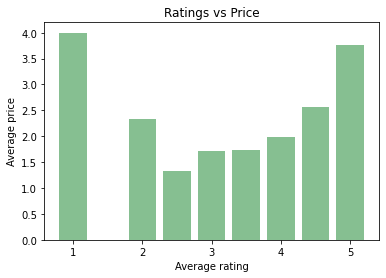

In [30]:
# Replace None with your code

# Calculate average price for each rating
rvg = business_df.groupby('rating').agg({'price': 'mean'})

# Plot results
fig, ax = plt.subplots()

ax.bar(x = list(rvg.index),
       height = list(rvg['price']),
       width = (0.4),
       color = '#86bf91')

ax.set(title = "Ratings vs Price", 
       xlabel = "Average rating", 
       ylabel = "Average price");

Is a higher price associated with a higher rating? (No need for any additional math/statistics, just interpret what you see in the plot.)

In [ ]:
# Replace None with appropriate text
"""
No, there's no association between price and higher rating.
"""

## Ratings vs Review Counts

Finally, let's look at ratings vs. review counts. You can analyze this relationship similarly to ratings vs. price.

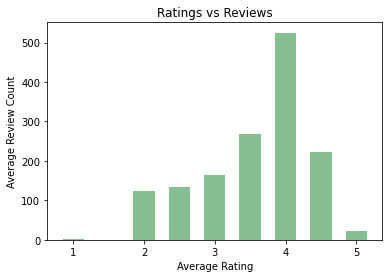

In [32]:
# Replace None with your code

# Calculate average review count for each rating
rating_review_count = business_df.groupby('rating').agg({'review_count': 'mean'})

# Plot results
fig, ax = plt.subplots()

ax.bar(x = list(rating_review_count.index),
       height = list(rating_review_count['review_count']),
       width = 0.3,
       color = '#86bf91')

ax.set(title = "Ratings vs Reviews", 
       xlabel = "Average Rating", 
       ylabel = "Average Review Count");

Is a higher number of reviews associated with a higher rating?

In [93]:
# Replace None with appropriate text
"""
Yes, higher rated restaurants (specifically 4 out of 5) receive more reviews.
"""

'\nYes, higher rated restaurants (specifically 4 out of 5) receive more reviews.\n'

## Level Up: Create a Folium Map

Make a map using Folium of the businesses you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

You can center the map around the latitude and longitude of the first item in your dataset.

In [50]:
business_df.iloc[0]

name            Prince Street Pizza
review_count                   3934
rating                          4.5
price                             1
latitude                    40.7231
longitude                  -73.9945
Name: 0, dtype: object

In [51]:
print(business_df.iloc[0]['latitude'])
print(business_df.iloc[0]['longitude'])

40.72308755605564
-73.99453001177575


In [54]:
# Replace None with appropriate code

# Import the library
import folium

# Set up center latitude and longitude
center_lat = business_df.iloc[0]['latitude']
center_long = business_df.iloc[0]['longitude']

# Initialize map with center lat and long
yelp_map = folium.Map([center_lat, center_long], zoom_start=13)

# Adjust this limit to see more or fewer businesses
limit=100

for business in full_dataset[:limit]:
    # Extract information about business
    lat = business_df.iloc[business]['latitude']
    long = business_df.iloc[business]['longitude']
    name = business_df.iloc[business]['name']
    rating = business_df.iloc[business]['rating']
    price = business_df.iloc[business]['price']
    details = "{}\nPrice: {} Rating:{}".format(name,price,rating)
    
    # Create popup with relevant details
    popup = None
    
    # Create marker with relevant lat/long and popup
    marker = None
    
    marker.add_to(yelp_map)
    
yelp_map

AttributeError: 'NoneType' object has no attribute 'add_to'

# 5. Create Presentation Notebook

Now that you've completed your project, let's put it into an easily presentable format so you can add it to your portfolio. To do this, we recommend completing the following steps outside of this notebook.

1. Create a new GitHub repository for your project.
2. Save a copy of this notebook into your local repository.
3. Edit the text and images in the notebook to present your project and help someone else understand it.
4. Run your notebook from start to finish, then **delete your API key** and save it.
5. Create a README.md file in your repository with a brief summary of your project.
6. Push your updated repository to GitHub to share with your instructor and employers!

# Level Up: Project Enhancements

After completing the project, you could consider the following enhancements if you have time:

* Save a cleaned version of your dataset in your repository, then modify the notebook to load and use that dataset for the analysis. This will allow others to replicate your analysis and avoid running their own API queries.
* Use `seaborn` to improve the styling of your visualizations
* Explain the implications of your findings for business owners or internal Yelp staff
* Repeat the project for another business category or location, and compare the results

# Summary

Nice work! In this lab, you've made multiple API calls to Yelp in order to paginate through a results set, prepared your data for analysis, and then conducted and visualized descriptive analyses. Well done!